# Deep Learning with PyTorch : Build a Generative Adversarial Network

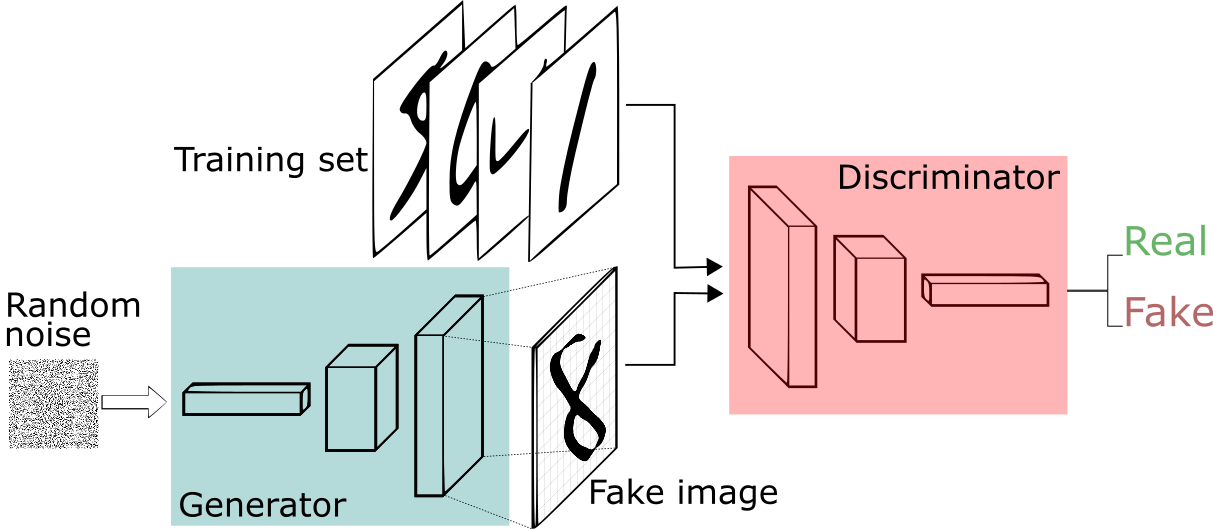

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

#optimizer parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.9

# Training Varibales

epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST('MNIST/',download = True, train = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17826560.82it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483699.20it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 880417.47it/s] 


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3705607.62it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
len(trainset)

60000

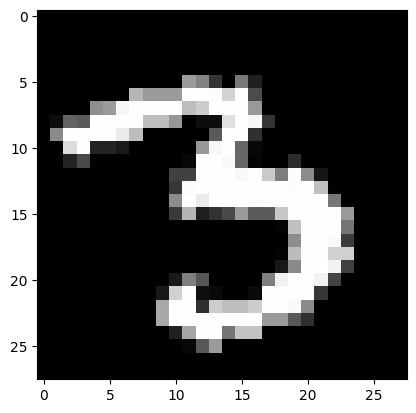

In [ ]:
image, label = trainset[12]
plt.imshow(image.squeeze(),cmap = 'gray')

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size = batch_size, shuffle = True)

In [ ]:
len(trainloader)

469

In [ ]:
dataiter = iter(trainloader)
images, _  = next(dataiter)

In [ ]:
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

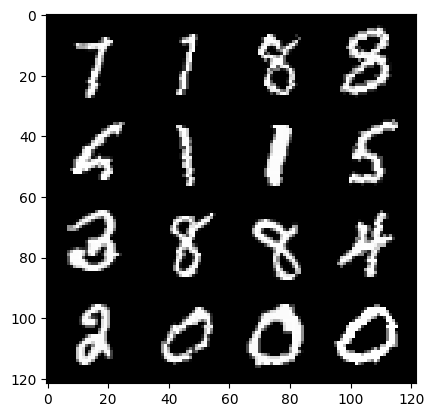

In [ ]:
show_tensor_images(images)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def disc_conv_block(in_channels,out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discrimiator(nn.Module):
  def __init__(self):
    super(Discrimiator,self).__init__()
    self.block_1 = disc_conv_block(1,16,3,2)
    self.block_2 = disc_conv_block(16,32,5,2)
    self.block_3 = disc_conv_block(32,64,5,2)
    self.flatten = nn.Flatten()
    self.Linear = nn.Linear(64,1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4  = self.flatten(x3)
    x5  = self.Linear(x4)

    return x5

In [ ]:
Disc = Discrimiator()
Disc.to(device)
summary(Disc,input_size = (1,28,28),batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 13, 13]             160
       BatchNorm2d-2          [128, 16, 13, 13]              32
         LeakyReLU-3          [128, 16, 13, 13]               0
            Conv2d-4            [128, 32, 5, 5]          12,832
       BatchNorm2d-5            [128, 32, 5, 5]              64
         LeakyReLU-6            [128, 32, 5, 5]               0
            Conv2d-7            [128, 64, 1, 1]          51,264
       BatchNorm2d-8            [128, 64, 1, 1]             128
         LeakyReLU-9            [128, 64, 1, 1]               0
          Flatten-10                  [128, 64]               0
           Linear-11                   [128, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def gen_conv_block(in_channels,out_channels,kernel_size,stride,final_block = False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = gen_conv_block(noise_dim,256,3,2)
    self.block_2 = gen_conv_block(256,128,4,1)
    self.block_3 = gen_conv_block(128,64,3,2)
    self.block_4 = gen_conv_block(64,1,4,2,final_block = True)

  def forward(self,r_noise_vec):
    x = r_noise_vec.view(-1,self.noise_dim,1,1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4  = self.block_4(x3)
    return x4

In [ ]:
Gene = Generator(noise_dim)
Gene.to(device)
summary(Gene,input_size = (1,noise_dim),batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [128, 256, 3, 3]         147,712
       BatchNorm2d-2           [128, 256, 3, 3]             512
              ReLU-3           [128, 256, 3, 3]               0
   ConvTranspose2d-4           [128, 128, 6, 6]         524,416
       BatchNorm2d-5           [128, 128, 6, 6]             256
              ReLU-6           [128, 128, 6, 6]               0
   ConvTranspose2d-7          [128, 64, 13, 13]          73,792
       BatchNorm2d-8          [128, 64, 13, 13]             128
              ReLU-9          [128, 64, 13, 13]               0
  ConvTranspose2d-10           [128, 1, 28, 28]           1,025
             Tanh-11           [128, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
Disc = Disc.apply(weights_init)
Gene = Gene.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [ ]:
Disc_opti = torch.optim.Adam(Disc.parameters(),lr = lr,betas = (beta_1,beta_2))
Gene_opti = torch.optim.Adam(Gene.parameters(),lr = lr,betas = (beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6812947312397744| G_loss : 0.6987062554115425


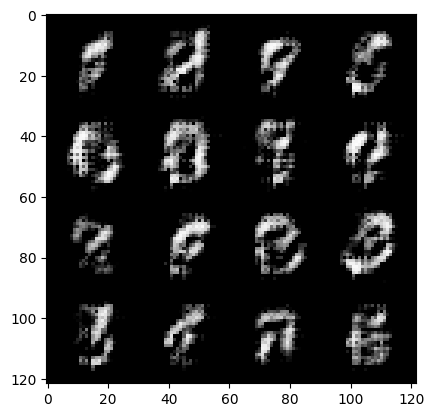

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6777033118296788| G_loss : 0.7114221696406285


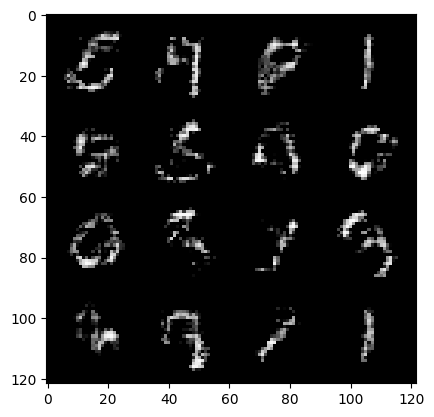

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.649039979174193| G_loss : 0.7445252233985137


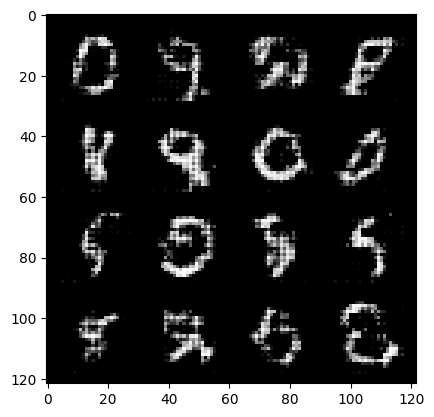

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6382619405606154| G_loss : 0.7600282177742101


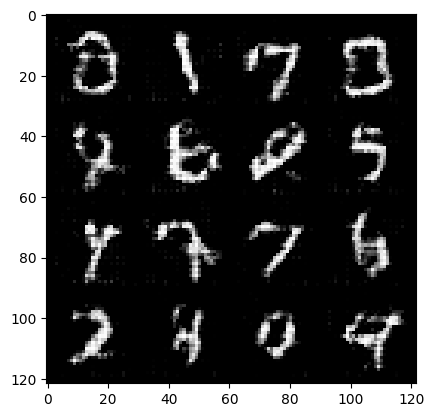

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.639899333021534| G_loss : 0.7661913639700997


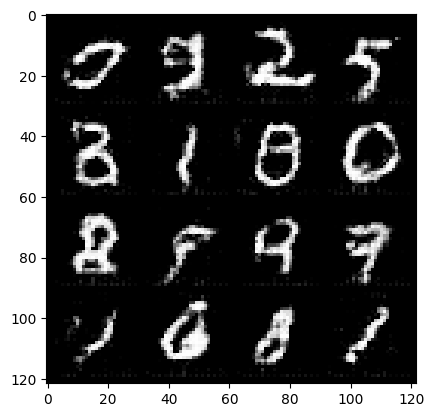

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.643801876985188| G_loss : 0.7697432158089904


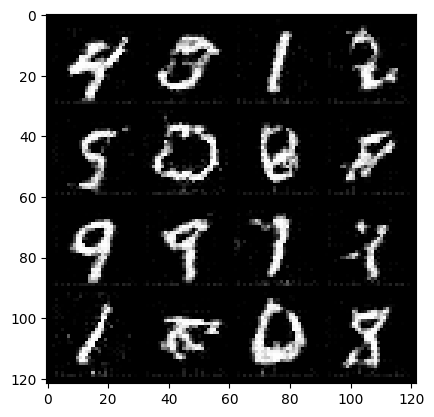

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6516876904440841| G_loss : 0.7649186784778831


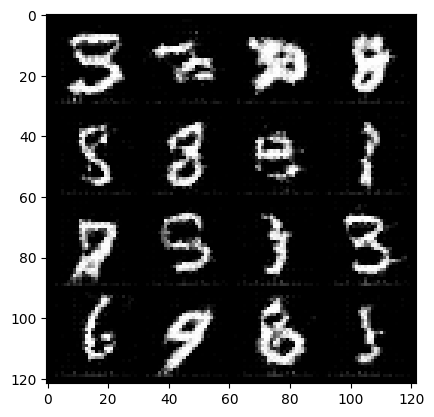

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6575174074945673| G_loss : 0.7595462528373133


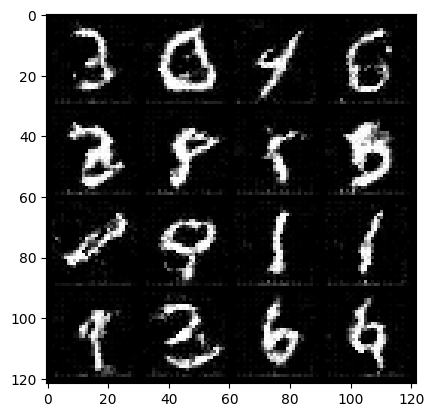

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6601957114520611| G_loss : 0.7566150580642066


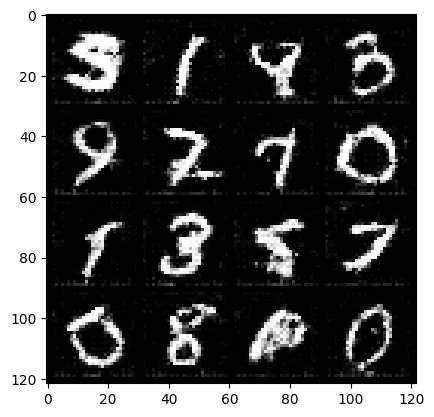

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6622599792887153| G_loss : 0.7554790647045128


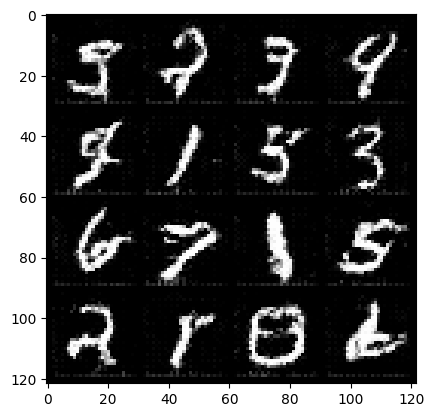

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6566072661739423| G_loss : 0.7645808234651968


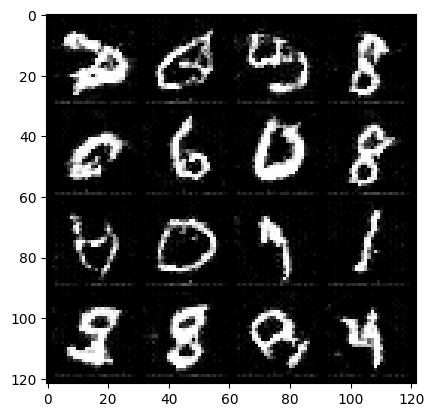

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6521269179610555| G_loss : 0.7731174280140192


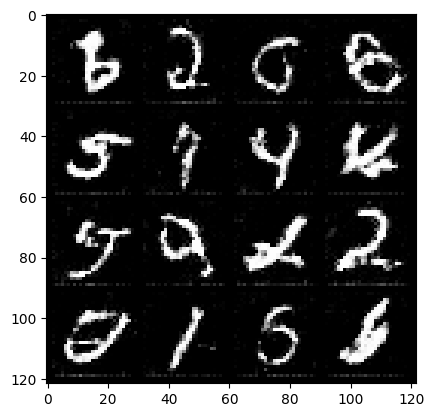

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6571017652432293| G_loss : 0.7673646632288056


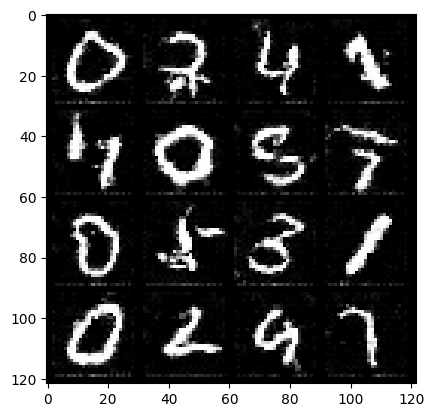

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6600091907261277| G_loss : 0.7659808640032689


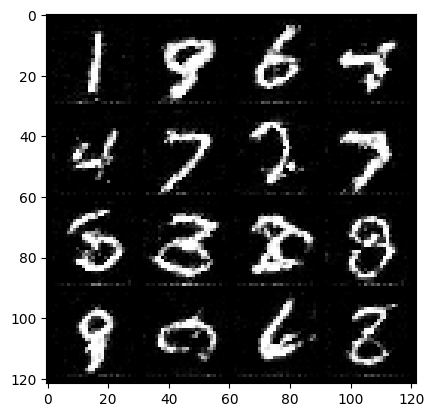

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6611023622789363| G_loss : 0.7632833263004767


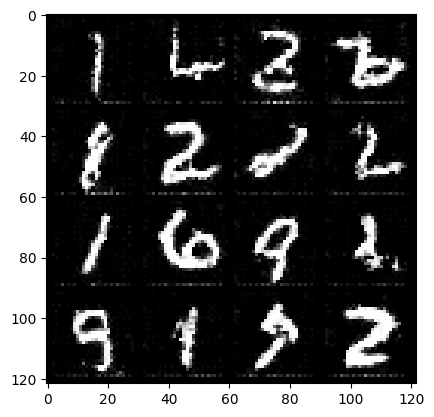

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6631846280494479| G_loss : 0.7615883879061701


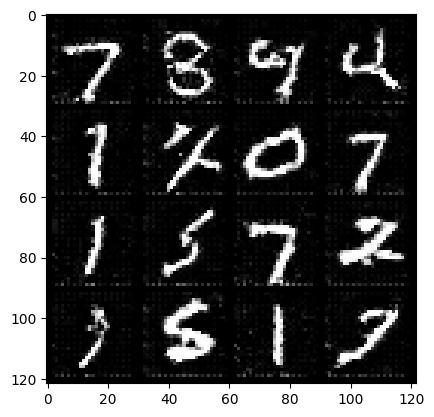

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6634180634769041| G_loss : 0.7608435821177354


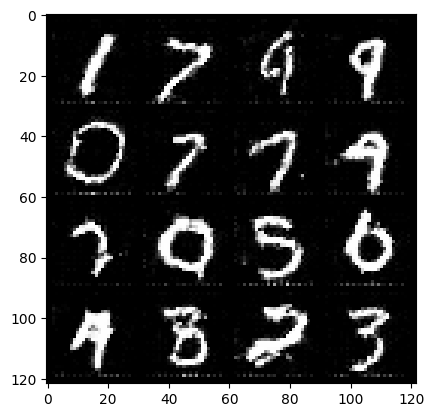

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.662276241443813| G_loss : 0.7624022967017281


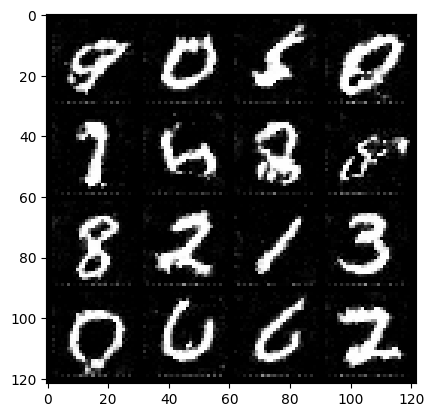

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6632253713190936| G_loss : 0.7636881593956368


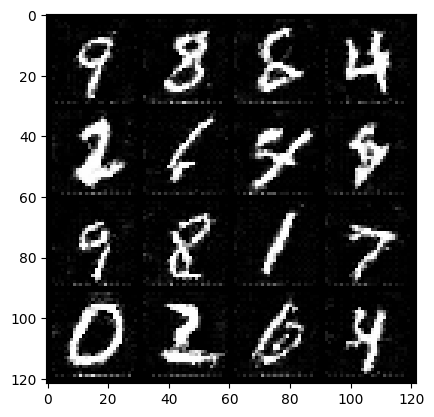

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6626305844483853| G_loss : 0.7633287356352247


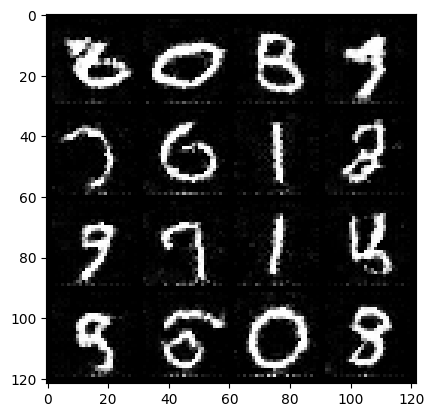

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img,_ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size,noise_dim,device = device)

    Disc_opti.zero_grad()
    fake_img = Gene(noise)
    D_pred = Disc(fake_img)
    D_fake_loss = fake_loss(D_pred)
    D_pred = Disc(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss+D_real_loss)/2

    D_loss.backward()
    Disc_opti.step()

    Gene_opti.zero_grad()
    noise  = torch.randn(batch_size,noise_dim,device = device)
    fake_img = Gene(noise)
    D_pred = Disc(fake_img)
    G_loss = real_loss(D_pred)

    G_loss.backward()
    Gene_opti.step()

    total_d_loss += D_loss.item()
    total_g_loss += G_loss.item()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch : {} | D_loss : {}| G_loss : {}".format(i+1,avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)



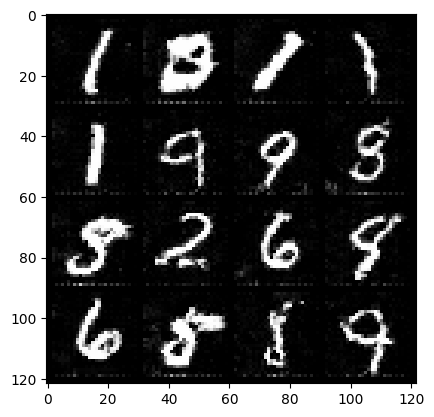

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = Gene(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya